In [1]:
import torch
import torch.nn as nn

from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
"""
import os
import sys
# for every .py file with classes inside add path of parent directory 
sys.path.append("/Users/carlovoss/jupyter_notebooks/masterarbeit/src/ai/models/")
sys.path.append("/Users/carlovoss/jupyter_notebooks/masterarbeit/src/ai/utils/")
"""
from models import LstmMse
from data_loader import DataPreperator, DataSet

# Hyperparameters

In [2]:
hyperparam = {
    "data" : {
        "stake_training_data" : 0.75, 
        "path" : '../../../data/vega_shrinkwrapper_original/NewBlade/'
    },
    "model" : {
        "input_size" : 7,
        "n_hidden" : 150,
        "sequence_size" : 50,
        "batch_size" : 8,
        "lstm_layer" : 3,
        "gaussian" : 1
    },
    "cycling_lr" : {
        # step_size is the number of training iterations (total samples/batch_size) per half cycle. 
        # Authors suggest setting step_size 2-8 x training iterations in epoch.
        "step_size" : (2048/8)*2, 
        # Mode can be one of {triangular, triangular2, exp_range}
        "mode" : "triangular", 
        "gamma" : 0.9995,
        "base_lr" : 0.016, 
        "max_lr" :0.1
    },
    "training": {
        "n_epochs" : 100,
        "patience" : 20,
    }
}

# Split train and test data

In [3]:
train_loader = DataPreperator(path=hyperparam['data']['path']+'NewBlade001.csv')
train_data, validation_data = train_loader.provide_data(stake_training_data=hyperparam['data']['stake_training_data'])


# Datahandler 

## Size of multivariate time series

In [4]:
dataset_train = DataSet(train_data, timesteps=hyperparam["model"]["sequence_size"])
dataset_validation = DataSet(validation_data, timesteps=hyperparam["model"]["sequence_size"])

# Data is shuffled because each mini batch is indipendent from each other, but samples of a minibatch are in chronological order
data_loader_training = DataLoader(dataset_train, batch_size=hyperparam["model"]["batch_size"], 
                                  num_workers=1, shuffle=True, drop_last=True)
data_loader_validation = DataLoader(dataset_validation, batch_size=hyperparam["model"]["batch_size"], 
                                    num_workers=1, shuffle=True, drop_last=True)

In [5]:
for batch_idx, data in enumerate(data_loader_training):
    x,y = data
    print('Data of batch: {}'.format(batch_idx))
    print("Size of input data: {}".format(x.size()))
    print("Size of target data: {}".format(y.size()))
    if batch_idx >=1: break

Data of batch: 0
Size of input data: torch.Size([8, 50, 7])
Size of target data: torch.Size([8, 7])
Data of batch: 1
Size of input data: torch.Size([8, 50, 7])
Size of target data: torch.Size([8, 7])


## Define Architecture of Neural Network
__With tanh activation function in fully connected layer__

### Loss function MSE

In [6]:
class LossModule(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate the module and assign them as
        member variables.
        """
        super(LossModule, self).__init__()

    def forward(self, output, target_data):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. 
        """
        # Compute loss
        mean_loss = torch.sum((output - target_data)**2, dim=1) / hyperparam["model"]["input_size"]
        mean_loss = torch.sum(mean_loss) / hyperparam["model"]["batch_size"]
        return mean_loss

## Training Loop
An epoch consists of a learning cycle over all batches of training data and an evaluation of the most recent model with the testing data. 

In [7]:
# Initialize model
torch.manual_seed(0)
model = LstmMse(batch_size=hyperparam['model']['batch_size'], input_dim=hyperparam['model']['input_size'], 
             n_hidden=hyperparam['model']['n_hidden'], n_layers=hyperparam['model']['lstm_layer'])


# Initialize optimizer and Cyclic Learning Rate
# lr=1. because of scheduler (1*learning_rate_schedular)
optimizer = torch.optim.SGD(model.parameters(), lr=1.)  

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=hyperparam['cycling_lr']['base_lr'], 
                                              max_lr=hyperparam['cycling_lr']['max_lr'], step_size_up=hyperparam['cycling_lr']['step_size'], 
                                              mode=hyperparam['cycling_lr']['mode'], gamma=hyperparam['cycling_lr']['gamma'])

print("Start model training")
# Create lists to save training loss and validation loss of each epoch
hist_loss = []
lr_find_lr = []

# Set first comparative value
lowest_loss = 99
trails = 0

for epoch in range(hyperparam['training']['n_epochs']):
    # Empty list for recording performance 
    epoch_training_loss = []
    epoch_validation_loss = []
    
    model.train()
    
    ##### Training #####
    for batch_number, data in enumerate(data_loader_training):
        # The LSTM has to be reinitialised, otherwise the LSTM will treat a new batch as a continuation of a sequence.
        # When batches of data are independent sequences, then you should reinitialise the hidden state before each batch. 
        # But if your data is made up of really long sequences and you cut it up into batches making sure that each batch 
        # follows on from the previous batch, then in that case you wouldn’t reinitialise the hidden state before each batch.
        # In the current workflow of class DataProvoider independent sequences are returned. 
        
        input_data, target_data = data
        
        hidden = model.init_hidden()
        
        # Zero out gradient, else they will accumulate between minibatches
        optimizer.zero_grad()
        
        # Forward propagation
        output = model(input_data, hidden)
         
        # Calculate loss
        criterion = LossModule()
        loss = criterion(output, target_data)
        epoch_training_loss.append(loss.item())
    
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)
        
    # Save mean of loss over all training iterations
    mean_epoch_training_loss = sum(epoch_training_loss) / float(len(epoch_training_loss))
    
    ##### Evaluation #####
    for batch_number, data in enumerate(data_loader_validation):
        input_data, target_data = data
        model.eval()
        hidden = model.init_hidden()
        
        output = model(input_data, hidden)
        # Calculate loss
        criterion = LossModule()
        loss = criterion(output, target_data)
        epoch_validation_loss.append(loss.item())
    
    # Save mean of loss over all validation iterations
    mean_epoch_validation_loss = sum(epoch_validation_loss) / float(len(epoch_validation_loss))
    
    # Save training and validation loss to history
    hist_loss.append({'epoch': epoch, 
                      'training': mean_epoch_training_loss, 
                      'validation': mean_epoch_validation_loss})
    
    print("-------- epoch_no. {} finished with eval loss {}--------".format(epoch, mean_epoch_validation_loss))
        
    # Check after every evaluation whether the latest model is the best one or not
    # If this is the case, set current score to best_score, reset trails and save the model.
    if mean_epoch_validation_loss < lowest_loss:
        trials = 0
        lowest_loss = mean_epoch_validation_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mean_epoch_validation_loss
        }, "../../../models/MSE_model/best_model.pt")
        print("Epoch {}: best model saved with loss: {}".format(epoch, mean_epoch_validation_loss))
    
    # Else: Increase trails by one and start new epoch as long as not too many epochs 
    # were unsuccessful (controlled by patience)
    else:
        trials += 1
        if trials >= hyperparam['training']['patience'] :
            print(f'Early stopping on epoch {epoch}')
            break  

# Safe results to csv file
df = pd.DataFrame(hist_loss)
print(df)
df.to_csv("../../../visualisation/files/history_MSE.csv", sep=";", index=False)

Start model training


/Users/carlovoss/jupyter_notebooks/masterarbeit/venv_pm/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([8, 7])
torch.Size([8, 7])


ZeroDivisionError: float division by zero

In [68]:
import numpy as np
import pandas as pd
x = range(len(lr_find_lr))
data = pd.DataFrame(data={'y': lr_find_lr, 'x': x})
data.head()

,y,x
0,0.016164,0
1,0.016328,1
2,0.016492,2
3,0.016656,3
4,0.016820,4


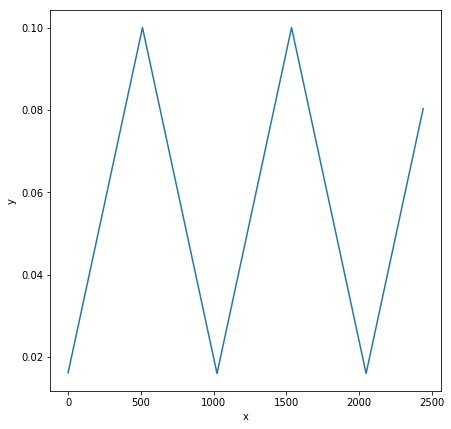

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots(figsize=(7, 7))
#ax.set(xscale="log")
sns.lineplot(x=data.x, y=data.y, ax=ax)
plt.show()